<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Pretrained_CNN_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageChops
from matplotlib.pyplot import imshow
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import random
import datetime
import shutil

!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.2 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"
dataset_path = "/content/dataset/content/splitted_dataset"

Mounted at /content/drive/


# Data preparation

In [ ]:
training_dir = dataset_path + "/training_set"
test_dir = dataset_path + "/test_set"
validation_dir = dataset_path + "/validation_set"
kfold_dir = dataset_path + "/kfold_set"

labels = ['battery', 'organic', 'paper', 'metal', 'plastic', 'trash', 'clothes', 'glass']
a = 0
b = 0
c = 0
d = 0
for l in labels:
  a += len(os.listdir(training_dir + "/" + str(l)))
  b += len(os.listdir(validation_dir + "/" + str(l)))
  c += len(os.listdir(test_dir + "/" + str(l)))
  d += len(os.listdir(kfold_dir + "/" + str(l)))

print("Training samples are: " + str(a))
print("Validation samples are: " + str(b))
print("Test samples are: " + str(c))
print("Kfold samples are: " + str(d))

Training samples are: 7040
Validation samples are: 2327
Test samples are: 2328
Kfold samples are: 8528


In [ ]:
path = training_dir + "/trash" 
files = os.listdir(path)
num_files = len(files)
print(training_dir)
print("Number of files in the directory:", num_files)

/content/dataset/content/splitted_dataset/training_set
Number of files in the directory: 880


With the following cell some BatchDataset objects are created to prepare our data for training and testing purposes

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 192
IMAGE_WIDTH = 192


train_dataset = image_dataset_from_directory(
    training_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

kfold_dataset = image_dataset_from_directory(
    kfold_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.
Found 8528 files belonging to 8 classes.


In [ ]:
print(train_dataset.class_names)

['battery', 'clothes', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']


# Feature extraction

We add a layer to resize all images at the same dimensions and another one to normalize tensors related to images.

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

VGG16 pretrained CNN is downloaded with all associated weights from a repository

In [ ]:
conv_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    classes=8,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
conv_base.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
conv_base.trainable = False

We build the model by adding some extra custom layer to the pretrained CNN

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = resize_and_rescale(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten(name='my_flatten')(x)
# x = layers.Dense(256, activation='relu', name='my_dense1')(x)
# x = layers.Dense(256, activation='relu', name='my_dense2')(x)
# x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation="softmax", name='predictions')(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 my_flatten (Flatten)        (None, 46080)             0         
                                                             

In [ ]:
dir_name = "/content/drive/My Drive/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'checkpoint_mobilenet.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

## Simple hold-out validation
We perform a classic holdout validation with a fixed validation set. Data are splitted in this way:
- Training 70%
- Validation 15%
- Test 15%

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks = callbacks_list
)
# MODELLO BASE 60/20/20 + CROP --> loss: 0.1583 - accuracy: 0.9534 - val_loss: 0.2664 - val_accuracy: 0.9081
# MODELLO BASE 70/15/15 NO CROP --> loss: 0.0970 - accuracy: 0.9790 - val_loss: 0.2075 - val_accuracy: 0.9355
# FINE-TUNING-conv5_block3_out --> loss: 0.1089 - accuracy: 0.9750 - val_loss: 0.2043 - val_accuracy: 0.9321
# FINE-TUNING-conv5_block3 --> loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.1871 - val_accuracy: 0.9519
# FINE-TUNING-conv5_block2 and conv5_block3 --> loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.2001 - val_accuracy: 0.9480
# FINE-TUNING-conv5_blovk1 and conv5_block2 and conv5_block3 --> loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.1831 - val_accuracy: 0.9566
# MODELLO BASE + DENSE + DROPOUT(0.5) --> loss: 0.0407 - accuracy: 0.9898 - val_loss: 0.1812 - val_accuracy: 0.9403
# MODELLO BASE + 2DENSE + 2DROPOUT(0.5) --> loss: 0.2655 - accuracy: 0.9059 - val_loss: 0.1952 - val_accuracy: 0.9355
# MODELLO BASE + DENSE + 2DROPOUT(0.1) --> loss: 4.7143e-04 - accuracy: 0.9997 - val_loss: 0.2546 - val_accuracy: 0.9544
# FINE-TUNING-conv5_blovk1 and conv5_block2 and conv5_block3 --> loss: 0.0193 - accuracy: 0.9950 - val_loss: 0.2549 - val_accuracy: 0.9424

Epoch 1/30
220/220 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.8243
Epoch 1: val_loss improved from inf to 0.22570, saving model to /content/drive/My Drive/checkpoint_mobilenet.h5
220/220 [==============================] - 30s 67ms/step - loss: 0.5363 - accuracy: 0.8243 - val_loss: 0.2257 - val_accuracy: 0.9269
Epoch 2/30
219/220 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9773
Epoch 2: val_loss improved from 0.22570 to 0.22536, saving model to /content/drive/My Drive/checkpoint_mobilenet.h5
220/220 [==============================] - 14s 63ms/step - loss: 0.0796 - accuracy: 0.9774 - val_loss: 0.2254 - val_accuracy: 0.9269
Epoch 3/30
220/220 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9979
Epoch 3: val_loss improved from 0.22536 to 0.20075, saving model to /content/drive/My Drive/checkpoint_mobilenet.h5
220/220 [==============================] - 16s 71ms/step - loss: 0.0258 - accuracy: 0.9979 - val_loss:

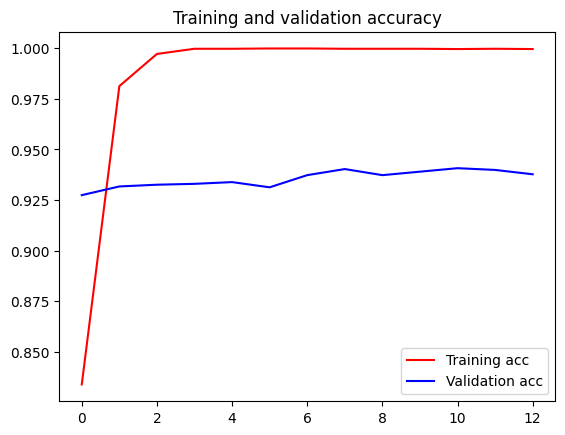

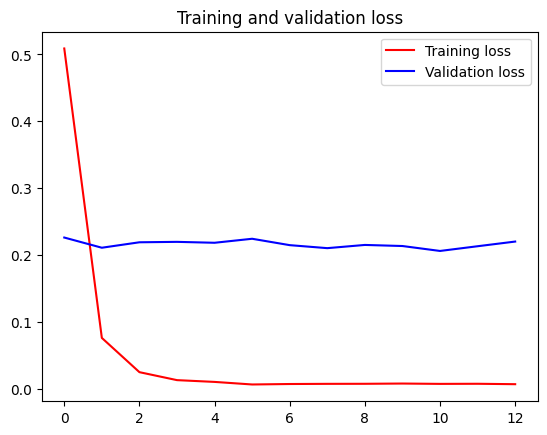

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
results = model.predict(test_dataset)

73/73 [==============================] - 4s 51ms/step


In [ ]:
model.evaluate(test_dataset)

73/73 [==============================] - 4s 53ms/step - loss: 0.1835 - accuracy: 0.9493


[0.18350794911384583, 0.949312686920166]

73/73 [==============================] - 5s 50ms/step
Classification report: 
[0 0 0 ... 7 7 7]
              precision    recall  f1-score   support

           0     0.7778    0.9754    0.8655       122
           1     0.9981    0.9671    0.9824      1095
           2     0.9491    0.8614    0.9031       303
           3     0.7651    0.9194    0.8352       124
           4     0.9367    0.9867    0.9610       150
           5     0.9544    0.9158    0.9347       297
           6     0.7984    0.8512    0.8240       121
           7     0.9407    0.9569    0.9487       116

    accuracy                         0.9394      2328
   macro avg     0.8900    0.9292    0.9068      2328
weighted avg     0.9450    0.9394    0.9407      2328



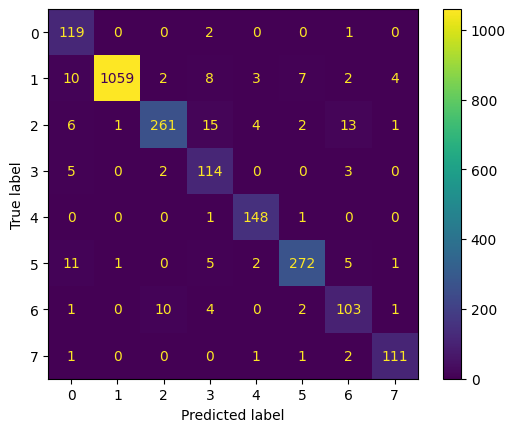

In [ ]:
y_score = model.predict(test_dataset)
y_pred = np.rint(y_score) # to have 0 or 1
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
print("Classification report: ")
print(y_pred.argmax(axis=1))
print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))


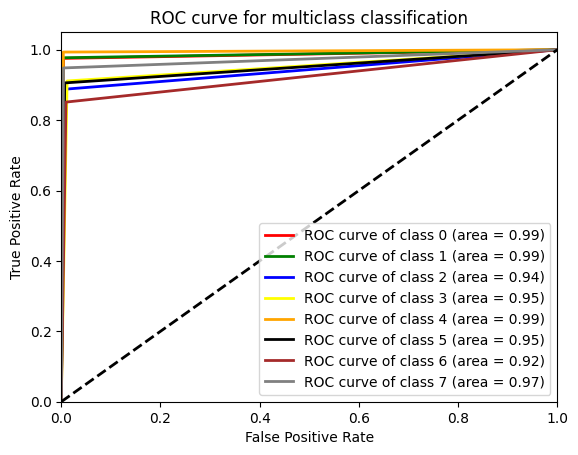

In [ ]:
# Convert multiclass labels to binary format
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'black', 'brown', 'grey']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multiclass classification')
plt.legend(loc="lower right")
plt.show()

### **Considerations**
Based on the provided results, it appears that this model is performing well in terms of both training and validation accuracy. The training accuracy is 0.9534, which means that the model is able to correctly classify the majority of the training data. The validation accuracy of 0.9081 is also quite good and suggests that the model is not overfitting the training data.

The loss values of 0.1583 and 0.2664 indicate that the model is doing a good job of minimizing the difference between predicted and actual values, both during training and validation.

Overall, these results suggest that this model is well-optimized and performing effectively in terms of accuracy and loss. However, it's important to note that these metrics don't necessarily provide a complete picture of model performance, and it's always a good idea to perform additional evaluation and analysis to ensure that the model is working as intended.


## 5-fold cross validation
First, data are prepared for a K-fold cross validation

In [ ]:
(kfold_img_np, kfold_label_np) = kfold_dataset

acc_per_fold = []
loss_per_fold = []
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(kfold_img_np, kfold_label_np):
   # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(kfold_img_np[train], 
                      kfold_label_np[train],
                      epochs=30,
                      callbacks = callbacks_list)

  # Generate generalization metrics
  scores = model.evaluate(kfold_img_np[test], kfold_label_np[test])
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


ValueError: ignored

In [ ]:
kfold_data = kfold_dataset.unbatch()
images = np.array(list(kfold_data.map(lambda x, y: x)))
labels = np.array(list(kfold_data.map(lambda x, y: y)))

print(len(labels))
print(len(images))
print(type(labels))
print(type(images))


In [ ]:
images = np.array(images)
labels = np.array(labels)

In [ ]:
k = 5
num_val_samples = len(images) // k
#print(num_val_samples)
validation_scores = []
for fold in range(k):
    # validation data: data from partition k
    val_data = images[fold * num_val_samples: (fold + 1) * num_val_samples]
    val_labels = labels[fold * num_val_samples: (fold + 1) * num_val_samples]
    # training data: data from all other partitions
    train_data = np.concatenate((images[:fold * num_val_samples], images[(fold+ 1) * num_val_samples:]), axis = 0)
    train_labels = np.concatenate((labels[:fold * num_val_samples], labels[(fold+ 1) * num_val_samples:]), axis = 0)
    # Note: labels must be split accordingly

    model.fit(train_data, train_labels, epochs=30)
    # Evaluate the model on the validation data
    validation_score = model.evaluate(val_data, val_labels)
    validation_scores.append(validation_score)    
    # it is better to delete the model and clear session to free memory

# validation score: average of the validation scores of the k folds
validation_score = np.average(validation_scores)

# train the final model on all non-test data available
model.fit(kfold_dataset, epochs=30, validation_data=validation_dataset)
test_score = model.evaluate(test_dataset)

# Fine-tuning

In [ ]:
conv_base.summary()

We unfreeze some layers of the convolutional base of the pretrained CNN in order to retrain them and we keep frozen the rest of the layers. We start to unfreeze layers from the bottom of the CNN (that has 5 convolutional levels). The last one is "conv5" composed by three block. So conv5_block3 is the last layer. We avoid to unfreeze Batch Normalization layers because during training, they uses the mean and variance of the current batch of data to normalize samples, and during inference, they uses an exponential moving average of the batch-wise mean and variance of the data seen during training.
BN layers should be kept frozen during fine-tuning, i.e. avoid updating internal mean and variance.

In [ ]:
conv_base.trainable = True
count = 0
set_trainable = False
for layer in conv_base.layers:
    if '_bn' in layer.name:
        set_trainable = False
    elif 'block5_conv3' in layer.name:
        set_trainable = True
        print(layer.name)
        count += 1
    elif 'block5_conv2' in layer.name:
        set_trainable = True
        print(layer.name)
        count += 1
    elif 'block5_conv1' in layer.name:
        set_trainable = True
        print(layer.name)
        count += 1
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print(count)

In [ ]:
conv_base.summary()

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

We can see that now about 9M of parameters are trainable after the unfreezing operation.

In [ ]:
model.summary()

In [ ]:
dir_name = "/content/drive/My Drive/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'garbage_classification_pretrained_fine_tuned_MOBILENET.h5')

callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=1e-3,
      patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks = callbacks_list
)

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylim(np.min(acc_1)-0.9, np.max(acc_1)+0.2)
# plt.ylim(np.min(val_acc_1)-0.9, np.max(val_acc_1)+0.2)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_score = model.predict(test_dataset)
y_pred = np.rint(y_score) # to have 0 or 1
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
print("Classification report: ")
print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# Hyperparameter tuning

In this section we run some experiments with Keras Tuner to find the optimal configuration for the hyperparameters of CNN selected for this project. We try to play with parameters such as learning rate of optimizer, number of hidden units of dense layer, activation function of dense layer and the presence or not of a dropout layer.

In [ ]:
# Create permanent folder in Google Drive
my_dir = "/content/drive/My Drive/project/"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

In [ ]:
def model_builder(hp): 

  inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
  x = resize_and_rescale(inputs)
  x = keras.applications.resnet_v2.preprocess_input(inputs)
  x = conv_base(x)
  x = keras.layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)

  # Decide whether to use or not dropout
  dropout_rate_hp = hp.Float('dropout_rate', min_value = 0, max_value = 0.5, step = 0.05)

  # Pick one of these activation functions
  activation = hp.Choice("activation", ["relu", "elu", "gelu"])

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  x = keras.layers.Dense(units=hp_units, activation=activation)(x)

  x = keras.layers.Dropout(dropout_rate_hp)(x)

  outputs = keras.layers.Dense(8, activation="softmax", name='predictions')(x)
  model = keras.Model(inputs, outputs)

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='kerasTunerMobileNet')

#tuner2 = kt.applications.HyperResNet(
  #                  model_builder,
   #                 include_top=True, 
    #                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
     #               directory=log_dir,
      #              project_name='10_kerasTuner')

In [ ]:
tuner.search_space_summary()

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(log_dir)
tuner.search(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[stop_early, tensorboard])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}and \
        the best dropout rate is {best_hps.get('dropout_rate')} and \
        the best activation function is {best_hps.get('activation')}.")

In [ ]:
tuner.results_summary()

In [ ]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir "$log_dir"

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)